## Wikipedia Time Series Analysis
This project is a multiple time series project from Kaggle, with the goal being predicting Wikipedia web views for 145k different pages. Training data ranges from July 2015 to December 2016, and predictions range from January 2017 to March 2017. This notebook is 5 part:

1. Data exploration
2. Model tuning
3. Modeling evaluation and selection
4. Forecasting
5. Conclusion

### 1. Data exploration
This section explores patterns in the training data and implements some preprocessing for visualization:
1. Parse out language, article, and access type from the URL
2. Look at frequency across languages
3. Plot total views per language 
4. Plot sample of random web pages per language
5. Plot top 5 pages per language
6. Look at patterns by day of week, language 

In [134]:
#data manipulation and plotting
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import re
import seaborn as sns
import itertools

#time series modeling
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.ar_model import AR
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.seasonal import seasonal_decompose
import pmdarima as pm
from pmdarima.arima.utils import ndiffs, nsdiffs
from pmdarima.model_selection import train_test_split
from pmdarima.metrics import smape
from fbprophet import Prophet
from fbprophet.plot import add_changepoints_to_plot

#utilities
from tqdm import tqdm
import warnings
import os
#ignore the warnings about not having different language fonts available 
warnings.filterwarnings(action='ignore') 

import logging
logger = logging.getLogger('ftpuploader')

In [2]:
#load data and downcast to integers
orig_train = pd.read_csv('/Users/christinejiang/Documents/Python/data/train_1.csv')
key = pd.read_csv('/Users/christinejiang/Documents/Python/data/key_1.csv')
submission = pd.read_csv('/Users/christinejiang/Documents/Python/data/sample_submission_1.csv')
second_train = pd.read_csv('/Users/christinejiang/Documents/Python/data/train_2.csv')

train = orig_train.fillna(0)
for col in train.columns[1:]:
    train[col] = pd.to_numeric(train[col], downcast = 'integer')

In [3]:
def find_lang(page):
    match = re.search('[a-z][a-z].wikipedia.org', page)
    if match:
        return match.group(0)[0:2]
    return 'na'

def find_article(page):
    match = re.search('[a-z][a-z].wikipedia.org.', page)
    if match:
        article_end = match.start()-1
        return(page[0:article_end])
    return 'na'

def find_access(page):
    match = re.search('.*.wikipedia.org.', page)
    if match:
        access_start = match.end()
        return(page[access_start:])
    return 'na'

train['Language'] = train['Page'].map(find_lang)
train['Article'] = train['Page'].map(find_article)
train['Access'] = train['Page'].map(find_access)

In [4]:
dates = train.iloc[:,1:551]
labels = train[['Article','Language','Access','Page']]
newtrain = pd.concat([labels, dates], axis = 1)

display(newtrain.head(2))
#newtrain['Total'] = newtrain.sum(axis=1)
newtrain['Language'].value_counts().sort_values(ascending=False)

,Article,Language,Access,Page,2015-07-01,2015-07-02,2015-07-03,2015-07-04,2015-07-05,2015-07-06,...,2016-12-22,2016-12-23,2016-12-24,2016-12-25,2016-12-26,2016-12-27,2016-12-28,2016-12-29,2016-12-30,2016-12-31
0,2NE1,zh,all-access_spider,2NE1_zh.wikipedia.org_all-access_spider,18,11,5,13,14,9,...,32,63,15,26,14,20,22,19,18,20
1,2PM,zh,all-access_spider,2PM_zh.wikipedia.org_all-access_spider,11,14,15,18,11,13,...,17,42,28,15,9,30,52,45,26,20


en    24108
ja    20431
de    18547
na    17855
fr    17802
zh    17229
ru    15022
es    14069
Name: Language, dtype: int64

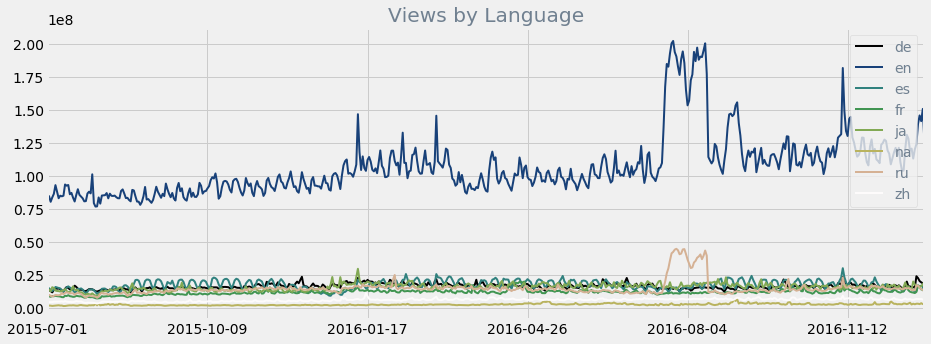

In [5]:
#plot the total views per language
def plot_groups(df, groupby):
    plt.style.use('fivethirtyeight')
    group = df.groupby(groupby).sum().reset_index()
    transpose = group.T
    transpose = transpose.rename(columns = transpose.iloc[0]).drop(transpose.index[0])
    figure = transpose.plot(figsize=(14,5), use_index = True, colormap = "gist_earth", lw=2)
    title=plt.title('Views by '+str(groupby), color='slategray')
    plt.legend(loc='upper left')
    plt.setp(plt.legend().get_texts(), color='slategray')
    return transpose

transposed = plot_groups(newtrain.iloc[:,:-1], 'Language')

In [6]:
#get random indices to plot
languages = newtrain['Language'].unique()
indices = np.random.randint(1,1400,size=3)
num_results = len(indices)
print(indices)

[636 412 976]


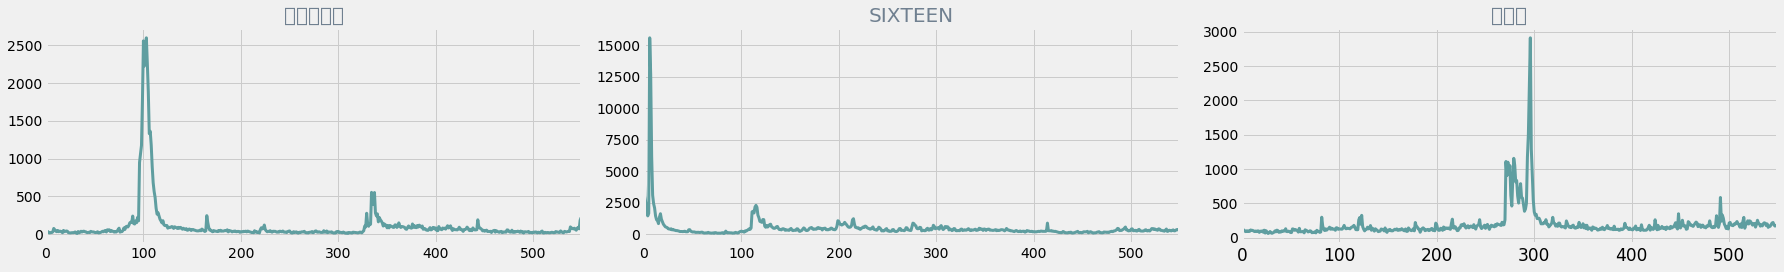

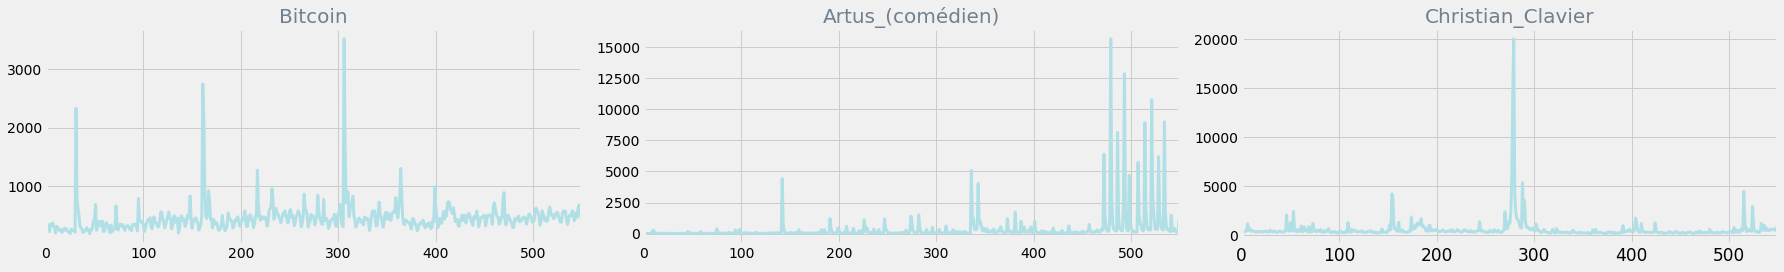

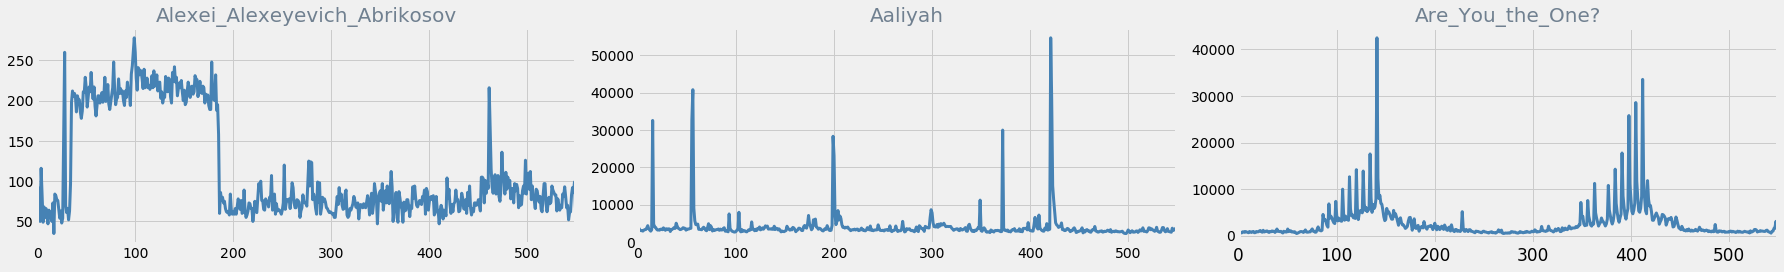

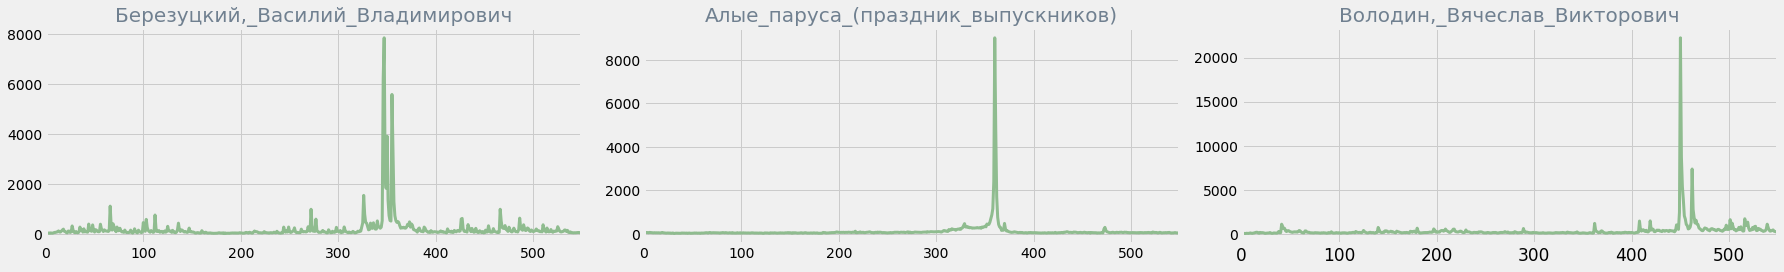

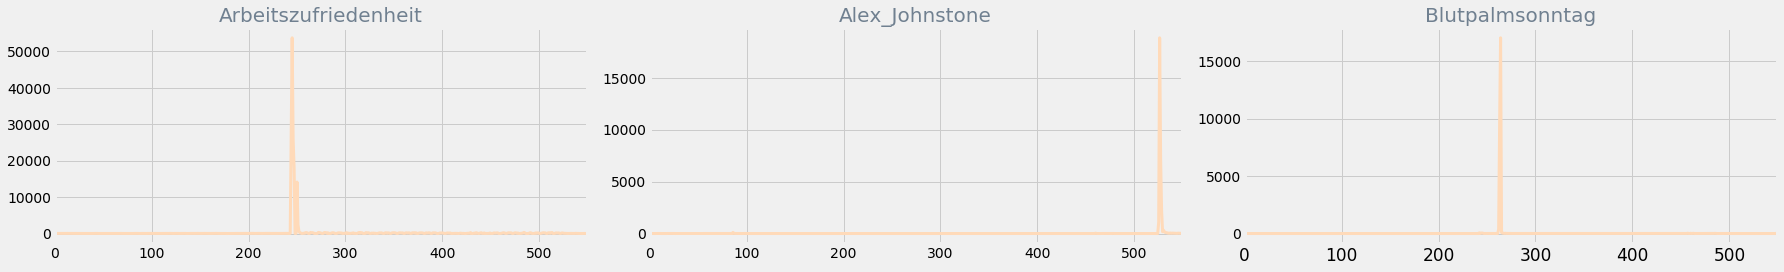

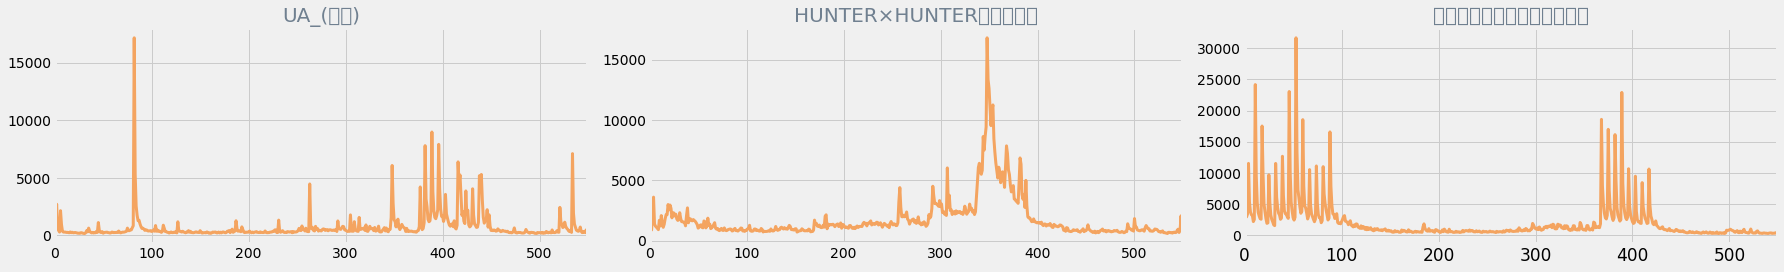

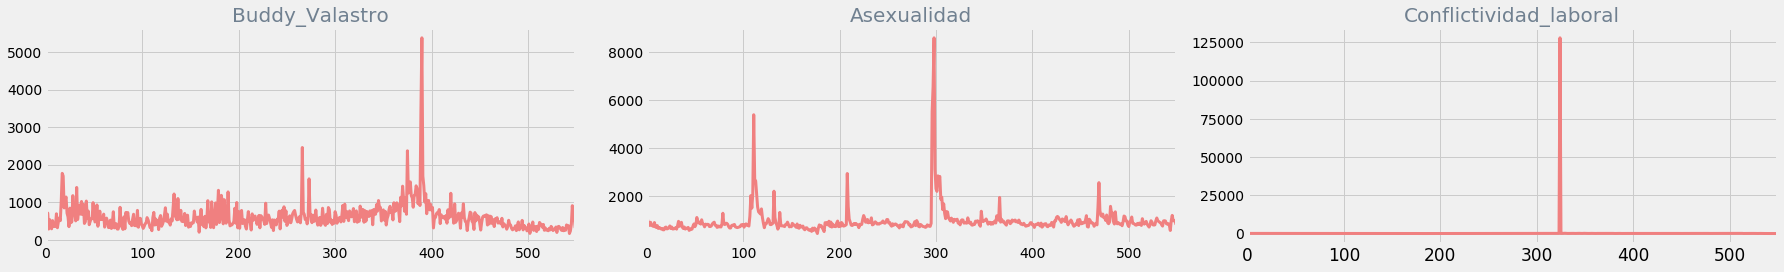

In [7]:
#plot a sample of pages for each language
colors = ['cadetblue','powderblue','steelblue','yellowgreen','darkseagreen','peachpuff','sandybrown','lightcoral']
dataframedict = {}
for i,language in enumerate(languages):
    dataframedict[language] = newtrain[newtrain['Language']==language]
    if language != 'na':
        langcolor = colors[i]
        fig, subaxes = plt.subplots(1,num_results,figsize=[25,4])
        pivottable = dataframedict[language].pivot_table(columns='Article')
        for i, index in enumerate(indices):
            singlerecord = pivottable.iloc[:,index]
            plt.xticks(fontsize=17)
            sns.tsplot(singlerecord,ax = subaxes[i],color=langcolor, linewidth=3)
            subaxes[i].set_title(singlerecord.name, color='slategray')
            subaxes[i].title.set_size(20)
            #fig.suptitle(language)
            plt.tight_layout()
    dataframedict[language]['Total'] = dataframedict[language].sum(axis=1)


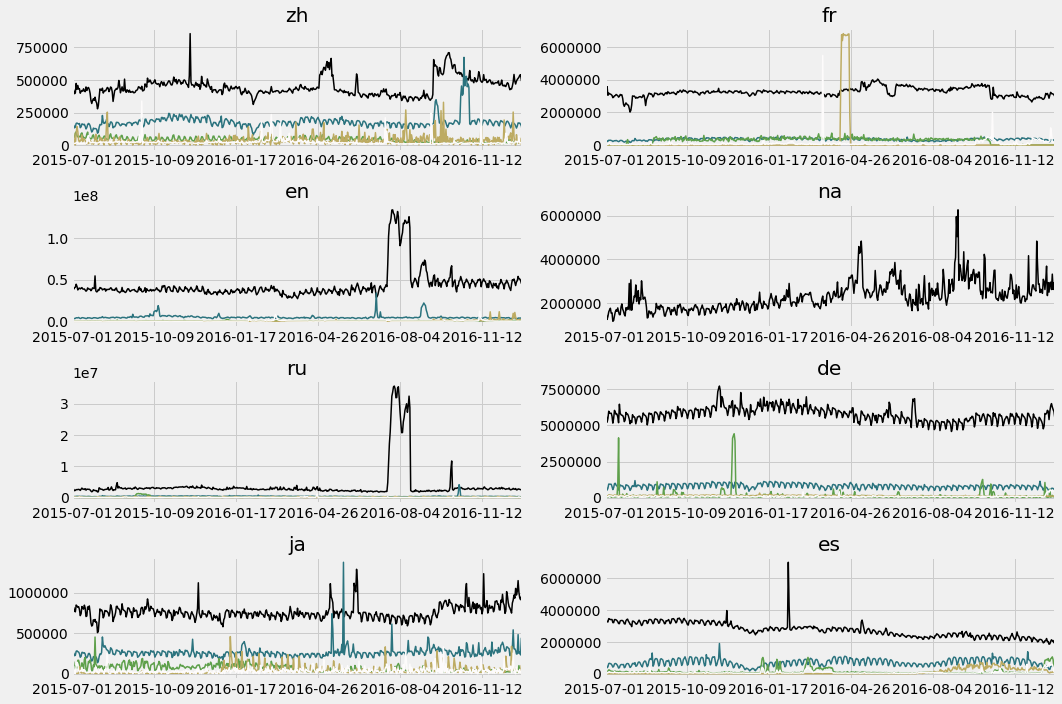

In [8]:
#plot top 5 pages for every language
fig, subaxes = plt.subplots(4,2,figsize=(15,10))
subaxes = subaxes.flatten()
x = [[a,b] for a in range(0,4) for b in range(0,2)]
for i,language in enumerate(languages):
    total_hits = dataframedict[language].groupby('Article').sum()
    top5sites = total_hits.nlargest(5, 'Total')
    axis = subaxes[x[i]]
    top5sites.T.iloc[:-1].plot(lw=1.5, ax=subaxes[i], colormap = 'gist_earth')
    subaxes[i].get_legend().remove()
    subaxes[i].set_title(language)
plt.tight_layout()

In [9]:
#plot patterns across days of week, access type
transposed = train.iloc[:,1:-3].T
transposed.columns = train['Page']
transposed.index = pd.DatetimeIndex(transposed.index)

In [10]:
transposed.head()
transposed['DayName'] = transposed.index.day_name()

In [11]:
groupby_days = transposed.groupby('DayName').sum()

### Time Series Modeling - ARIMA

In [12]:
class TimeSeries:
    def __init__(self, ts):
        self.ts = ts
        self.df = pd.DataFrame(ts).rename(columns={0:'Hits'})
        self.adf_statistic = self.stationarity_check()[0]
        self.pvalue = self.stationarity_check()[1]
        self.stationary = self.stationarity_check()[2]
        
    def stationarity_check(self):
        ts = self.ts
        stationarity = adfuller(ts)
        adf_statistic = stationarity[0]
        pvalue = stationarity[1]
        if stationarity[0] < stationarity[4]['5%']:
            stationary = True
        else:
            stationary = False
        return adf_statistic, pvalue, stationary
            
    def plot_diffs(self):
        plt.style.use('fivethirtyeight')
        ts = self.ts
        fig, axes = plt.subplots(3,3,figsize=(18,10))
        axes = axes.reshape(9,)
        for i in range(0,3):
            if i == 0:
                ts.plot(ax=axes[0], lw=2)
                plot_acf(ts, ax=axes[1])
                plot_pacf(ts, ax=axes[2])
                axes[0].set_title('Original Series')
            if i > 0:
                lag = ts.diff(i)
                axis_start = i**2+2
                lag.plot(ax=axes[axis_start], lw=2)
                plot_acf(lag[i:], ax=axes[axis_start+1])
                plot_pacf(lag[i:], ax=axes[axis_start+2])
                axes[axis_start].set_title('Lag of '+str(i))
            plt.tight_layout()
            
    def plot_rolling(self, n=12):
        ts = self.ts
        fig, axes = plt.subplots(1,figsize=(10,4))
        ts.rolling(n).std().plot(color='darkseagreen', ax=axes, lw=2)
        ts.plot(ax=axes, color='lightcoral', lw=2)
        ts.rolling(n).mean().plot(ax=axes, lw=2)
        plt.title('Time Series with Rolling Statistics')
        legend = axes.legend(['Rolling Std.','Original','Rolling Avg.'])
        
    def decompose(self, zoom=True):
        ts = self.ts
        #plt.style.use('seaborn')
        mul_result = seasonal_decompose(ts, model = 'multiplicative', period=7)
        plt.rcParams['figure.figsize'] = (10,4)
        fig = mul_result.plot().suptitle('Multiplicative')
        add_result = seasonal_decompose(ts, model = 'additive', period=7)
        #fig2 = add_result.plot().suptitle('Additive')
        if zoom:
            df = mul_result.seasonal.to_frame()
            df['day'] = df.index.day_name()
            df.index = df['day']
            df.drop('day',axis=1,inplace=True)
            fig = df[0:15].plot(kind='bar', figsize=(11,3), color='darkseagreen') 
            plt.title('Seasonal Trend')
            fig.get_legend().remove()
        return mul_result, add_result
            
    def auto_arima(self):
        ts = self.ts
        train, test = train_test_split(ts, test_size = 0.25)

        autoarima = pm.auto_arima(train, start_p=0, start_q=0, d=None, max_p=3, max_q=3, max_order=5,
                    m=7, seasonal=True, stepwise = True)

        train.plot(lw=3, label='actual train')
        test.plot(lw=3, label= 'actual test', color='yellowgreen')
        predictions, confint = autoarima.predict(test.shape[0], return_conf_int=True)

        predictions_series = pd.Series(predictions, index = test.index)
        predictions_series.plot(lw=3, color='orangered', label='predictions')
        fitted_series = pd.Series(autoarima.predict_in_sample(start=0, end=train.shape[0]-1), index = train.index)
        fitted_series.plot(lw=3, color='orangered', label='fitted')
        lower_series = pd.Series(confint[:, 0], index=test.index)
        upper_series = pd.Series(confint[:, 1], index=test.index)
        plt.fill_between(lower_series.index, lower_series, upper_series, color='gray',alpha=0.25)
        plt.legend(loc='upper left')
        
        display(autoarima.summary())
        fig = autoarima.plot_diagnostics(figsize=(10,6))
        plt.tight_layout()
    
        squared_error = mean_squared_error(test, predictions_series)
        mean_error = np.sqrt(squared_error)
        percent_error = mean_error/ts.mean()
        smape_value = smape(test, predictions_series)
        print(f'''
        mean error: {mean_error}
        percent_error: {percent_error}
        smape: {smape_value}''')
        return mean_error, percent_error, smape_value

In [13]:
#function to make a dataframe for any article
def make_df_article(article):
    totals = newtrain[newtrain['Article']==article].sum()
    rows = totals[4:-1].astype(float)
    rows.index = pd.DatetimeIndex(rows.index)
    return rows

def make_df_page(page):
    totals = newtrain[newtrain['Page']==page].sum()
    rows = totals[4:-1].astype(float)
    rows.index = pd.DatetimeIndex(rows.index)
    return rows

#create timeseries object
myseries = make_df_article('Bill_Nye')
timeseries = TimeSeries(myseries)

adf: -9.638212792381553, 
p-value: 1.5459408542225872e-16,
stationary: True


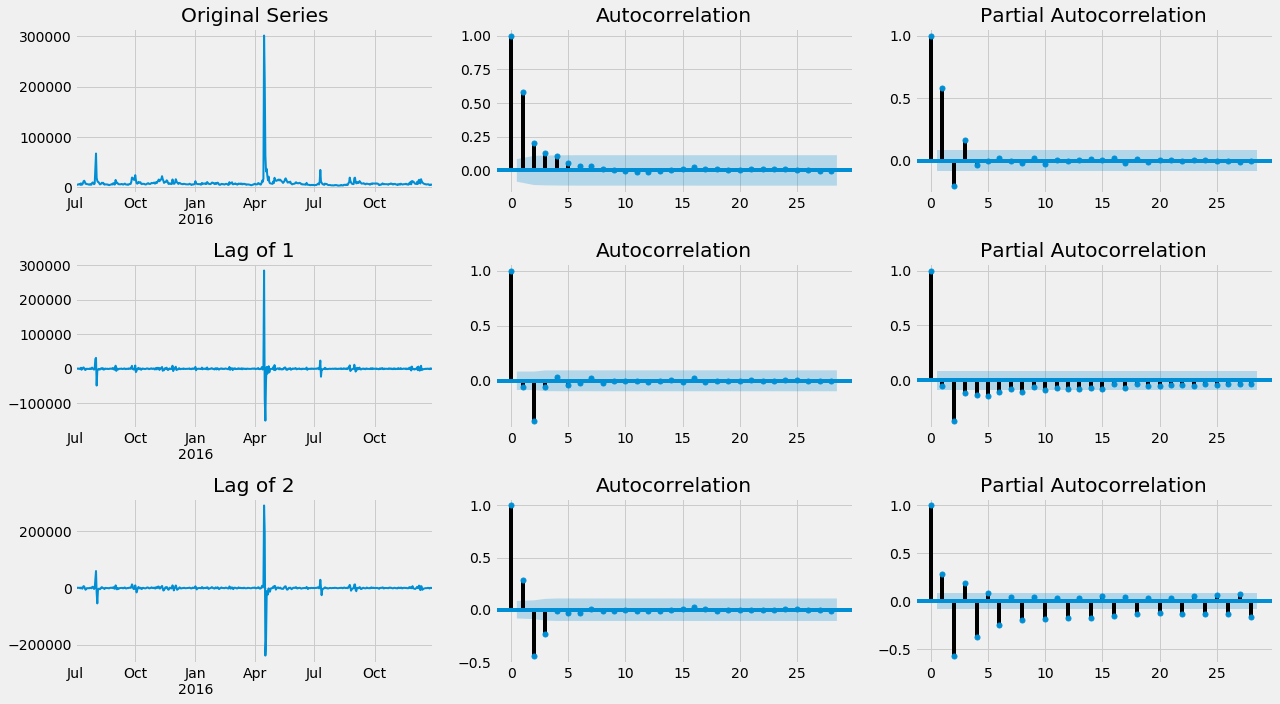

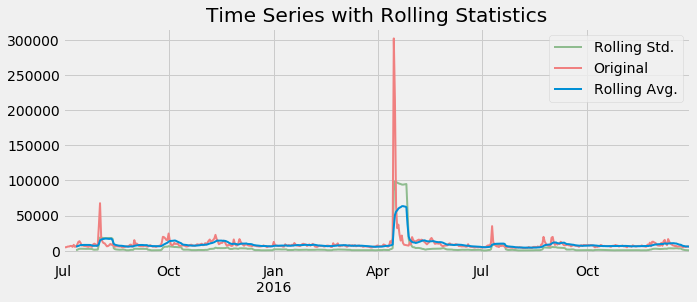

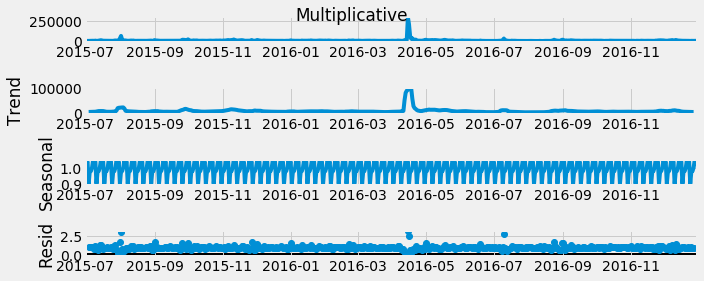

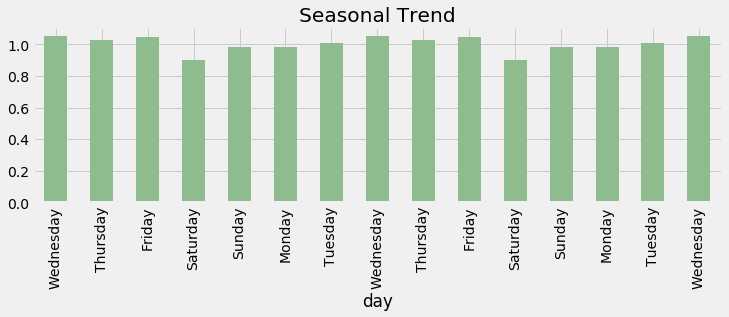

In [14]:
#call each method on the object
adf_statistic, pvalue, stationary = timeseries.stationarity_check()
print(f'''adf: {adf_statistic:}, 
p-value: {pvalue},
stationary: {stationary}''')

timeseries.plot_diffs()
timeseries.plot_rolling()
mul, add = timeseries.decompose()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  411
Model:               SARIMAX(1, 0, 2)   Log Likelihood               -4525.924
Date:                Sun, 08 Mar 2020   AIC                           9061.848
Time:                        11:24:50   BIC                           9081.941
Sample:                             0   HQIC                          9069.797
                                - 411                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept   4378.1782   3711.318      1.180      0.238   -2895.871    1.17e+04
ar.L1          0.5603      0.329      1.703      0.089      -0.085       1.205
ma.L1          0.1646      0.347      0.474      0.635      -0.515       0.844
ma.L2         -0.1871      0.264     -0.709      0.478      -0.704       0.330
sigma2      2.187e+08      2.649   8.26e+07      0.000    2.19e+08    2.19e+08
===================================================================================
Ljung-Box (Q):                        3.25   Jarque-Bera (JB):           2132387.23
Prob(Q):                              1.00   Prob(JB):                         0.00
Heteroskedasticity (H):              22.19   Skew:                            18.18
Prob(H) (two-sided):                  0.00   Kurtosis:                       353.99
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 1.52e+22. Standard errors may be unstable.
"""


        mean error: 3424.6226995253683
        percent_error: 0.3648484823040032
        smape: 35.47616059385218


(3424.6226995253683, 0.3648484823040032, 35.47616059385218)

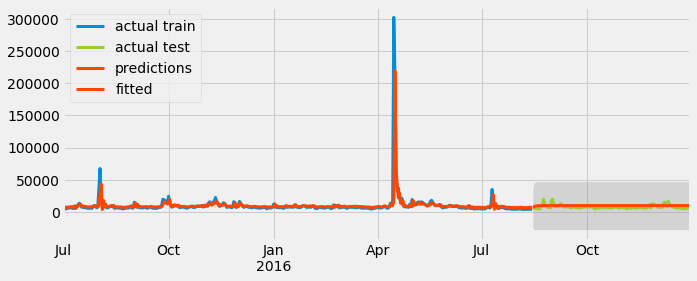

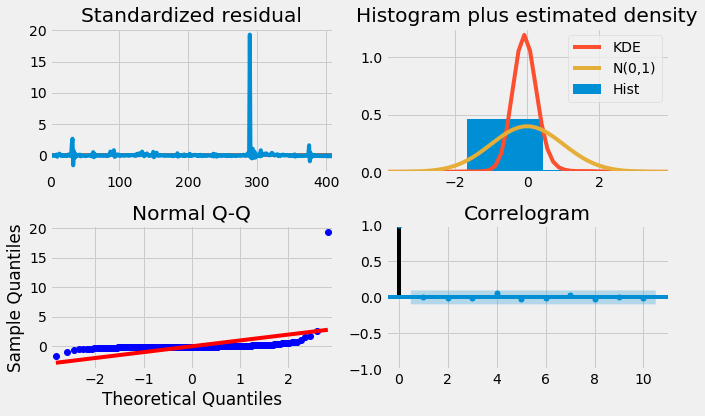

In [15]:
timeseries.auto_arima()

In [16]:
#things to understand:
#aic
#smape
#ar vs ma process
#svg did not converge
#seasonal?

In [20]:
submission_key = pd.merge(submission, key)
datelist = pd.date_range('2017-01-01', periods=60).date.tolist()

class TSPrediction:
    def __init__(self, page):
        self.page = page
        self.ts = self.transform()
        self.test = self.make_predictions()[0]
        self.train = self.make_predictions()[1]
        self.autoarima = self.make_predictions()[2]
        self.predictions = self.make_predictions()[3]
        
    def transform(self):
        page = self.page
        ts = newtrain[newtrain['Page']==page]
        transposed = ts.T.iloc[4:]
        transposed.columns = ['Hits']
        return transposed
        
    def make_predictions(self):
        ts = self.ts
        page = self.page
        test, train = train_test_split(ts, test_size = 0.25)
        autoarima = pm.auto_arima(ts, start_p=0, start_q=0, d=None, max_p=3, max_q=3, max_order=5,
                    m=7, seasonal=True, stepwise = True)
        predictions = autoarima.predict(60)
        predictions = pd.DataFrame(predictions, index = datelist).rename(columns={0:'Predicted'})
        predictions['Page'] = [page + '_' + str(x) for x in predictions.index]
        return train, test, autoarima, predictions[['Page','Predicted']]

In [21]:
submission_key.head()

,Id,Visits,Page
0,bf4edcf969af,0,!vote_en.wikipedia.org_all-access_all-agents_2...
1,929ed2bf52b9,0,!vote_en.wikipedia.org_all-access_all-agents_2...
2,ff29d0f51d5c,0,!vote_en.wikipedia.org_all-access_all-agents_2...
3,e98873359be6,0,!vote_en.wikipedia.org_all-access_all-agents_2...
4,fa012434263a,0,!vote_en.wikipedia.org_all-access_all-agents_2...


In [23]:
pages = newtrain['Page']
submission_data = pd.DataFrame()

for i,page in (enumerate(pages)):
    if i<2:
        timeseries = TSPrediction(page)
        predicted_values = timeseries.predictions
        second_train_page = second_train[second_train['Page']==page].iloc[:,1:].T
        second_train_page.index = pd.DatetimeIndex(second_train_page.index)
        second_train_dates = second_train_page.loc['2017-01-01':'2017-03-01']
        second_train_dates.columns = ['Actual']
        predicted_df = pd.concat([predicted_values, second_train_dates],axis=1)
        submission_data = submission_data.append(predicted_df[['Page','Predicted','Actual']])
        
submission_data['Article'] = [x[0:len(x)-11] for x in submission_data['Page']]

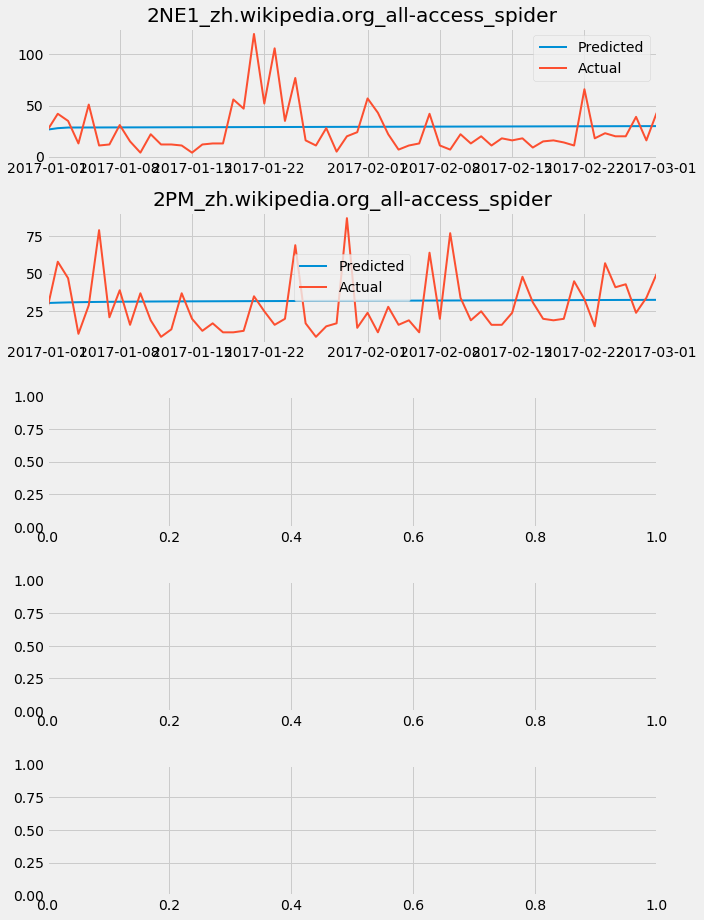

In [24]:
fig, axes = plt.subplots(5,1,figsize=(10,13))

for i,article in enumerate(submission_data['Article'].unique()):
    plotting = submission_data[submission_data['Article']==article]
    plotting[['Predicted','Actual']].plot(ax=axes[i],lw=2)
    axes[i].set_title(article)
plt.tight_layout()

In [25]:
smape(submission_data['Actual'],submission_data['Predicted'])

59.291750417620825

In [26]:
submission_data.head()
final_submission = pd.merge(submission_key, submission_data, how='inner',on='Page')
final_submission = final_submission[['Id','Predicted','Actual']]
final_submission.head()

,Id,Predicted,Actual
0,ff8c1aade3de,26.517722,26.0
1,6a4de5b43179,27.934241,42.0
2,559a1ab24535,28.565121,35.0
3,8bd4a4dea5a3,28.589668,13.0
4,fb31ab105824,28.614215,51.0


### Time Series Modeling - Prophet


In [ ]:
#make a class to fit prophet, make predictions
#plot decomposition
#calculate MAPE and MAE

class ProphetSeries:
    def __init__(self, article):
        self.timeseries = timeseries
        
    def make_df():
        
    def fit_prophet():
        

In [241]:
def make_prophet_df(page):
    df = orig_train[orig_train['Page']==page].iloc[:,1:].T
    df = df.reset_index().rename(columns={'index':'ds', 0:'y'})
    return df

def fit_prophet(df):
    marker = int(df.shape[0]*0.75)
    train = df[0:marker]
    test = df[marker:]
    prophet = Prophet(changepoint_prior_scale = 0.5).fit(train)
    future = prophet.make_future_dataframe(periods=len(test)+60)
    forecast = prophet.predict(future)
    fig0 = prophet_df.plot(figsize = (7,4))
    fig1 = prophet.plot(forecast, figsize = (7,4))
    a = add_changepoints_to_plot(fig1.gca(), prophet, forecast)
    fig2 = prophet.plot_components(forecast, figsize = (7,6))
    return forecast

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seaso

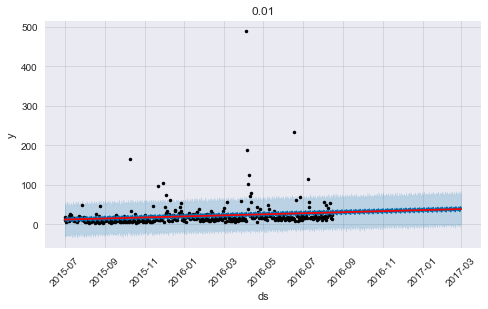

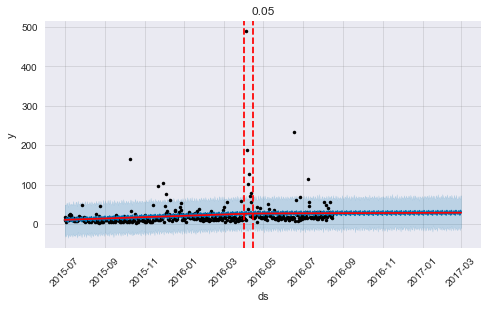

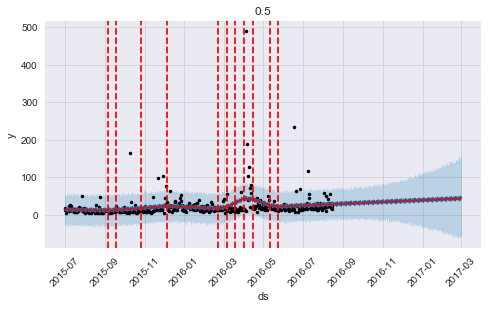

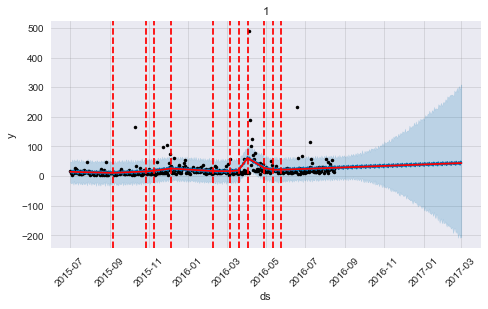

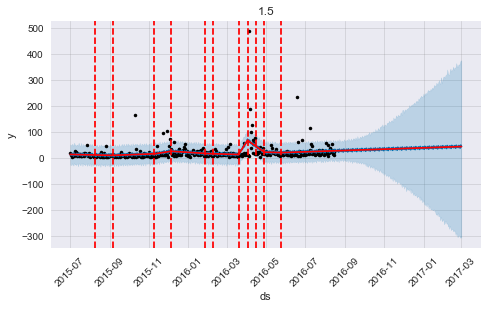

In [260]:
plt.style.use('seaborn')

marker = int(prophet_df.shape[0]*0.75)
train = df[0:marker]
test = df[marker:]

for changepoint in [0.01, 0.05, 0.5, 1, 1.5]:
    prophet = Prophet(changepoint_prior_scale = changepoint).fit(train)
    future = prophet.make_future_dataframe(periods=len(test)+60)
    forecast = prophet.predict(future)

#     fig0 = prophet_df.plot(figsize = (7,4))
#     plt.xticks(rotation=45)

    fig1 = prophet.plot(forecast, figsize = (7,4))
    a = add_changepoints_to_plot(fig1.gca(), prophet, forecast)
    plt.xticks(rotation=45)
    plt.title(changepoint)

#     prophet.plot_components(forecast, figsize = (7,6))
#     plt.xticks(rotation=45)


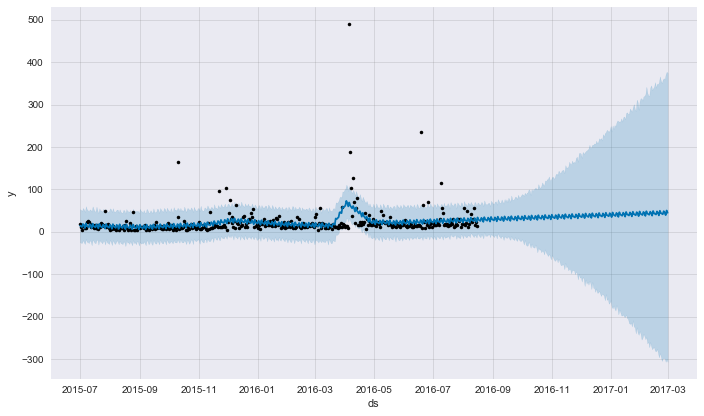

In [296]:
fig = prophet.plot(forecast)

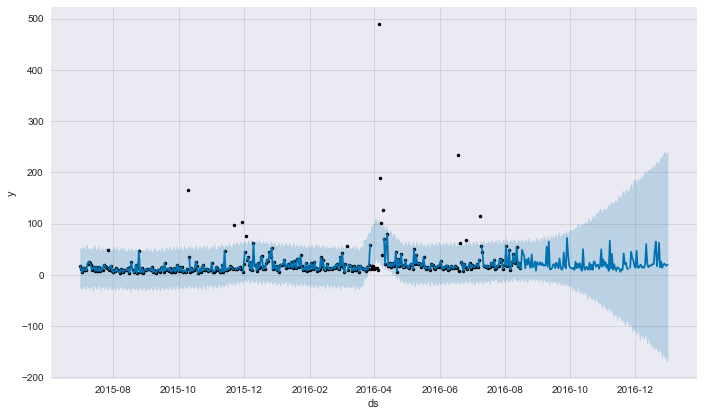

In [297]:
fig = prophet.plot(merged_forecast)

In [293]:
merged_forecast['yhat'] = merged_forecast['newy']
merged_forecast = merged_forecast.drop(['newy'],axis=1)


In [295]:
merged_forecast[merged_forecast['ds'] > '2016-04-01']

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,weekly,weekly_lower,weekly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
276,2016-04-02,68.625153,32.933448,111.008686,68.625153,68.625153,4.093783,4.093783,4.093783,4.093783,4.093783,4.093783,0.0,0.0,0.0,NaN
277,2016-04-03,66.900614,30.710436,105.912212,66.900614,66.900614,0.666368,0.666368,0.666368,0.666368,0.666368,0.666368,0.0,0.0,0.0,NaN
278,2016-04-04,65.176075,23.655420,96.300261,65.176075,65.176075,-5.439325,-5.439325,-5.439325,-5.439325,-5.439325,-5.439325,0.0,0.0,0.0,NaN
279,2016-04-05,63.451536,32.525554,107.987083,63.451536,63.451536,5.444913,5.444913,5.444913,5.444913,5.444913,5.444913,0.0,0.0,0.0,NaN
280,2016-04-06,61.726997,26.068231,100.113307,61.726997,61.726997,0.013907,0.013907,0.013907,0.013907,0.013907,0.013907,0.0,0.0,0.0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
545,2016-12-27,39.338631,-147.109082,234.582950,-156.848426,225.869020,5.444913,5.444913,5.444913,5.444913,5.444913,5.444913,0.0,0.0,0.0,20.0
546,2016-12-28,39.421977,-161.163654,240.427496,-159.551571,227.614560,0.013907,0.013907,0.013907,0.013907,0.013907,0.013907,0.0,0.0,0.0,22.0
547,2016-12-29,39.505324,-157.125663,237.814310,-163.010192,229.185985,-1.641056,-1.641056,-1.641056,-1.641056,-1.641056,-1.641056,0.0,0.0,0.0,19.0
548,2016-12-30,39.588670,-169.858122,235.819007,-165.419291,230.757410,-3.138590,-3.138590,-3.138590,-3.138590,-3.138590,-3.138590,0.0,0.0,0.0,18.0


In [276]:
prophet_df['ds'] = pd.to_datetime(prophet_df['ds'])
merged_forecast = pd.merge(prophet_df, forecast, on = 'ds')

def outlier_detection(x):
    if x['y'] > x['yhat_upper'] or x['y'] < x['yhat_lower']:
        return np.nan
    else:
        return x['y']

merged_forecast['yhat'] = merged_forecast.apply(outlier_detection,axis=1)

In [284]:
merged_forecast[merged_forecast['newy'].isna()]

,ds,y,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,weekly,weekly_lower,weekly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat,newy
26,2015-07-27,49.0,12.825621,-30.392492,44.958424,12.825621,12.825621,-5.439325,-5.439325,-5.439325,-5.439325,-5.439325,-5.439325,0.0,0.0,0.0,7.386296,NaN
101,2015-10-10,165.0,13.904115,-17.999388,56.166586,13.904115,13.904115,4.093783,4.093783,4.093783,4.093783,4.093783,4.093783,0.0,0.0,0.0,17.997898,NaN
144,2015-11-22,97.0,21.588990,-18.777064,58.591176,21.588990,21.588990,0.666368,0.666368,0.666368,0.666368,0.666368,0.666368,0.0,0.0,0.0,22.255357,NaN
151,2015-11-29,104.0,24.329421,-12.446516,59.112789,24.329421,24.329421,0.666368,0.666368,0.666368,0.666368,0.666368,0.666368,0.0,0.0,0.0,24.995789,NaN
155,2015-12-03,75.0,25.895381,-8.610994,61.254766,25.895381,25.895381,-1.641056,-1.641056,-1.641056,-1.641056,-1.641056,-1.641056,0.0,0.0,0.0,24.254326,NaN
249,2016-03-06,56.0,15.053359,-21.730536,52.625489,15.053359,15.053359,0.666368,0.666368,0.666368,0.666368,0.666368,0.666368,0.0,0.0,0.0,15.719727,NaN
272,2016-03-29,11.0,53.067680,22.824252,95.134893,53.067680,53.067680,5.444913,5.444913,5.444913,5.444913,5.444913,5.444913,0.0,0.0,0.0,58.512593,NaN
273,2016-03-30,18.0,56.957048,18.794338,93.972741,56.957048,56.957048,0.013907,0.013907,0.013907,0.013907,0.013907,0.013907,0.0,0.0,0.0,56.970955,NaN
274,2016-03-31,17.0,60.846416,24.155023,98.830735,60.846416,60.846416,-1.641056,-1.641056,-1.641056,-1.641056,-1.641056,-1.641056,0.0,0.0,0.0,59.205361,NaN
275,2016-04-01,12.0,64.735785,22.289887,101.512866,64.735785,64.735785,-3.138590,-3.138590,-3.138590,-3.138590,-3.138590,-3.138590,0.0,0.0,0.0,61.597195,NaN


In [ ]:
#improvements:
#add holidays per language
#plot the differences between different changepoint options
#compare mape across different models
#also try the add_country_holidays method
#do something with outliers?